# Probabilistic Methods for predictive uncertainty analysis applied to groundwater models

**Overview**

Methods of global Uncertainty Analyis: 

+ Introduction: Monte-Carlo Simulation
+ Test Plans: 
  + DoX 
  + Latin Hypercube
  + Pseudo-Random (Markov-Chain)

+ Monte-Carlo Filtering
+ GLUE
+ (Null-Space Monte-Carlo (PEST))

**Other Topics**

-	Visualization on test data set
-	Tim Example
-	FEFLOW Example
-	Bayes Method explained

**Further Reading**

Saltelli et al, *Global Sensitivity Analysis: The Primer*

Keith Beven, *Environmental Modelling: An Uncertain Future?*

## Monte-Carlo Simulation

### Example Model

The Example Model is a cross-section, steady-state groundwater flow model. It simulates the flow of water through a dam:

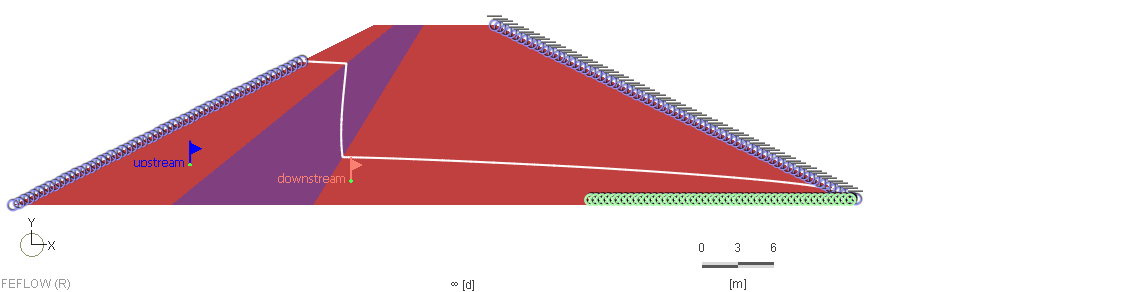

The model has a number of parameters and primary model results:

parameters:
+ hydr. conductivity of dam body (sand)
+ hydr. conductivity of sealing (clay)
+ porosity (body and sealing)
+ water level in reservoir
+ leakage (transfer rate) of drain 

observations:
+ head upstream of the sealing
+ head downstream of the sealing
+ flux from reservoir
+ flux into drain
+ flux into seepage (if drain is insufficient)

The following code cells encapsulate the FEFLOW model as a python function called `run_model(parameter)` that returns a dataframe of the results.

In [1]:
# the model is encapsulated in this code:

import sys
import os
import platform

# load IFM
ifmversion = '71'  # choose version here
arch = platform.architecture()[0][:2]
if 'FEFLOW' + ifmversion + '_ROOT' not in os.environ:
    raise EnvironmentError('FEFLOW' + ifmversion + '_ROOT Environment Variable not set!')
sys.path.insert(0, os.environ['FEFLOW' + ifmversion + '_ROOT'] + '\\bin' + arch)
import ifm
print("IFM API v."+str(ifm.getKernelVersion()))

IFM API v.7107


In [2]:
# load example model
doc = ifm.loadDocument("./example_data/dam_seepage.fem")

# create a dictionary of sets
selections = {}
for i in range(doc.getNumberOfSelections(ifm.Enum.SEL_ELEMENTAL)):
    ee = [e for e in range(doc.getNumberOfElements()) if doc.selectionItemIsSet(ifm.Enum.SEL_ELEMENTAL, i, e)]
    selections[doc.getSelectionName(ifm.Enum.SEL_ELEMENTAL, i)] = set(ee)
for i in range(doc.getNumberOfSelections(ifm.Enum.SEL_NODAL)):
    ee = [e for e in range(doc.getNumberOfElements()) if doc.selectionItemIsSet(ifm.Enum.SEL_NODAL, i, e)]
    selections[doc.getSelectionName(ifm.Enum.SEL_NODAL, i)] = set(ee)
selections.keys()

['Body', 'Domain', 'q_drain', 'q_seepage', 'q_reservoir', 'Sealing']

In [3]:
import pandas as pd

# define model function
def run_model(k_body = 10,    # [m/d]
          k_sealing = 10, # [m/d]
          porosity = 0.2, # [-]
          transfer = 1e-5, # [1/d]
          head = 12):     # [m]

    # assign parameters and run model:
    for e in selections["Body"]:
        doc.setMatConductivityValue2D(e, k_body)
    for e in selections["Sealing"]:
        doc.setMatConductivityValue2D(e, k_sealing)
    for e in range(doc.getNumberOfElements()):
        doc.setMatFlowTransferIn(e, transfer)
        doc.setMatFlowTransferOut(e, transfer)
        doc.setMatUnsatPorosity(e, porosity)
    for n in selections["q_reservoir"]:
        if doc.getZ(n) > head:  # node is dry
            doc.setBcFlowTypeAndValueAtCurrentTime(n, ifm.Enum.BC_NONE, 0, 0.)
        else:
            doc.setBcFlowTypeAndValueAtCurrentTime(n, ifm.Enum.BC_DIRICHLET, 0, head)
    doc.startSimulator()
    
    # get results (fluxes and heads) and provide return as a dataframe
    times, values, itemnames = doc.getHistoryValues(ifm.Enum.HIST_FFLUX, 0)  # 7 = MFLUX
    df_flux = pd.DataFrame(values, columns=times, index=itemnames, )
    times, values, itemnames = doc.getHistoryValues(ifm.Enum.HIST_HEAD, 0)  # 7 = MFLUX
    df_head = pd.DataFrame(values, columns=times, index=itemnames, )

    df = pd.concat([df_head, df_flux])
    df.columns = ["initial", "result"]
    df.drop(columns="initial", inplace=True)
    return df

In [4]:
# test run
print("Results of the model:")
run_model(head=9, k_sealing=0.01, transfer=1)

Results of the model:


,result
h_upstream,8.998875
h_downstream,0.757639
q_seepage,-0.000190
q_reservoir,0.206018
q_drain,-0.205826


### Model Parameters 

#### Define Prior Knowledge

The knowledge about the parameters is not deterministic, meaning that we know their values only as a range of possible parameter values. These are typically approximated as [Probability Density Functions (PDF)](https://en.wikipedia.org/wiki/Probability_density_function "Wikipedia"). Examples (Uniform, Normal and Log-Normal) are shown below.

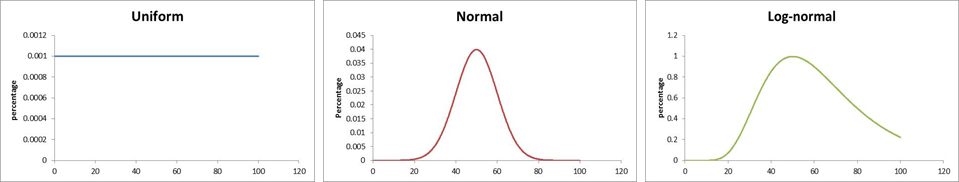

For the case of this exercise we assume that the material parameters of the model are (Gaussian-) normal distributed and can be described by their mean value and standard deviation.

The easiest way to define the values is to create an Excel table:

In [5]:
df_priorknowledge = pd.read_excel("./prior_knowledge.xlsx")
df_priorknowledge.set_index("parameter", inplace=True)
df_priorknowledge

,zone,PDF,mean,stdev
parameter,,,,
conductivity_body,Body,log-normal,8.6400,0.500000
conductivity_sealing,Sealing,log-normal,0.0864,0.632456
porosity,Domain,normal,0.2000,0.200000


In [6]:
# to get a particular cell value, use:
df_priorknowledge.loc["conductivity_body", "mean"]

8.64

#### Creating a sample 

There are multiple ways in python to create a random sample, we will use `numpy.random` here:

Text(0.5,1,u'mean 8.64, sigma 0.25')

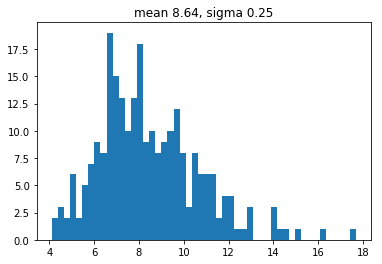

In [7]:
from math import log, exp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

n_samples = 250

mean = df_priorknowledge.loc["conductivity_body", "mean"]
sigma = df_priorknowledge.loc["conductivity_body", "stdev"]**2
sample = np.random.lognormal(log(mean), sigma, n_samples)

plt.hist(sample, bins=50)
plt.title("mean {}, sigma {}".format(mean, sigma))

Repeating this for all three material parameters, we can create a number of parameter sets. Because Monte-Carlo Simulations usually run a large number of models (typically in the hundreds or thousands), we use pandas to organize the data.

First we create a new data frame and then create random samples (of equal length) for the different parameters.

In [8]:
# create a new data frame:
df_simulations = pd.DataFrame()

In [9]:
# add the conductivity of the body (we simply use the sample we just created)
df_simulations["conductivity_body"] = sample

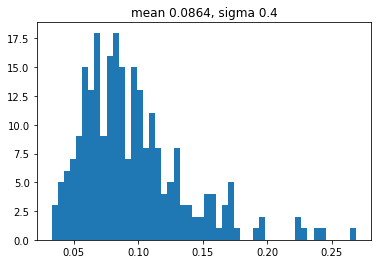

In [10]:
# add the other parameters
mean = df_priorknowledge.loc["conductivity_sealing", "mean"]
sigma = df_priorknowledge.loc["conductivity_sealing", "stdev"]**2
sample = np.random.lognormal(log(mean), sigma, n_samples)
plt.hist(sample, bins=50)
plt.title("mean {}, sigma {}".format(mean, sigma))

df_simulations["conductivity_sealing"] = sample

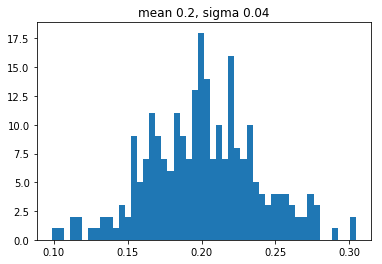

In [11]:
# add the other parameters
mean = df_priorknowledge.loc["porosity", "mean"]
sigma = df_priorknowledge.loc["porosity", "stdev"]**2
sample = np.random.normal(mean, sigma, n_samples)
plt.hist(sample, bins=50)
plt.title("mean {}, sigma {}".format(mean, sigma))

df_simulations["porosity"] = sample

These are all the parameters that we want to vary at this place. Therefore, our test data set is complete.
It is a good idea to store and have a look at the data at this place, e.g. by exporting it to Excel.

**NOTE:** It would be a valid approach to create the complete data set in Excel, and import it into the script.

In [12]:
df_simulations.to_excel("out_simulations.xlsx")
df_simulations

,conductivity_body,conductivity_sealing,porosity
0,9.376085,0.103821,0.203140
1,6.083403,0.089210,0.153487
2,6.798915,0.083286,0.170221
3,8.696379,0.065599,0.304615
4,6.369990,0.102663,0.255863
5,9.732650,0.065484,0.199067
6,6.722493,0.100664,0.112131
7,6.598755,0.173832,0.274713
8,7.097622,0.044139,0.148194
9,5.054297,0.155145,0.237077


#### Performing the model runs

Now it is time to run the models.



In [13]:
#df_simulations = pd.read_excel("out_simulations.xlsx")

In [14]:
df_simulations.columns

Index([u'conductivity_body', u'conductivity_sealing', u'porosity'], dtype='object')

In [15]:
def fab(row):
    return run_model(k_body = row[u'conductivity_body'],
                     k_sealing = row[u'conductivity_sealing'],
                     porosity = row[u'porosity']).result 

In [16]:
df_results = df_simulations.apply(fab, axis=1)
df_results.to_excel("out_results.xlsx")
df_results

,h_upstream,h_downstream,q_seepage,q_reservoir,q_drain
0,11.989088,4.204607,-2.351930,2.352438,-0.000411
1,11.986483,4.710323,-1.892093,1.892589,-0.000463
2,11.988195,4.379422,-1.846931,1.847337,-0.000429
3,11.991970,3.568639,-1.606052,1.606379,-0.000344
4,11.985504,4.887363,-2.128187,2.128536,-0.000481
5,11.992697,3.396185,-1.633461,1.633828,-0.000326
6,11.986278,4.753697,-2.125746,2.126109,-0.000468
7,11.979592,5.860136,-3.114276,3.114682,-0.000576
8,11.993162,3.280164,-1.115142,1.115496,-0.000312
9,11.977507,6.184481,-2.635564,2.635727,-0.000609


In [17]:
df_results = pd.read_excel("out_results.xlsx")

### Evaluating the result

#### Model Results (Predictive Uncertainty)

Checking the range of possible outcomes is now straight forward, simply plot the frequency as a scatter plot:

Text(0.5,1,u'Total Seepage through Dam')

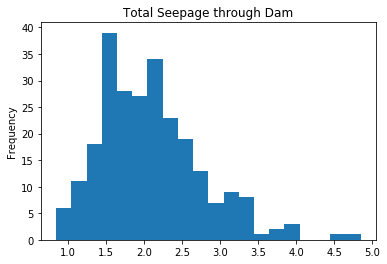

In [18]:
(-df_results.q_seepage).plot.hist(bins=20)
plt.title("Total Seepage through Dam")

it can be seen that there is quite a significant range of results, with seeapage amounts between 1.0 and 4.5 per day. Let's get some key values:

In [19]:
df_results.mean()

h_upstream      11.988673
h_downstream     4.217856
q_seepage       -2.093618
q_reservoir      2.093981
q_drain         -0.000411
dtype: float64

In [20]:
df_results.min()

h_upstream      11.968890
h_downstream     2.447229
q_seepage       -4.844918
q_reservoir      0.847055
q_drain         -0.000707
dtype: float64

In [21]:
df_summary = pd.DataFrame()
df_summary["min"] = df_results.min()
df_summary["mean"] = df_results.mean()
df_summary["max"] = df_results.max()
df_summary

,min,mean,max
h_upstream,11.968890,11.988673,11.996063
h_downstream,2.447229,4.217856,7.304318
q_seepage,-4.844918,-2.093618,-0.846753
q_reservoir,0.847055,2.093981,4.845102
q_drain,-0.000707,-0.000411,-0.000225


#### Sensitivity

One of the most important outcomes of the sensitivity analysis is to identify the parameters that are important to the model result. In a Monte-Carlo Simulation, this can be easily done using scatter plots.



Text(0.5,1,u'porosity vs. seepage')

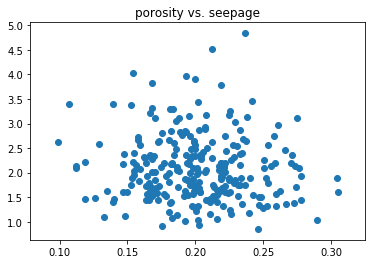

In [22]:
plt.scatter(df_simulations.porosity, df_results.q_reservoir)
plt.title('porosity vs. seepage')

The scatter does not show a correlation between porosity and seepage. This is expected, as storage has no effect in a steady state model. 

The conductivity should be more influential:

Text(0.5,1,u'body conductivity vs. seepage')

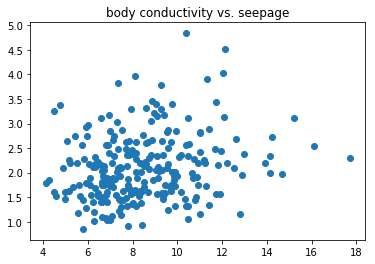

In [23]:
plt.scatter(df_simulations.conductivity_body, df_results.q_reservoir)
plt.title('body conductivity vs. seepage')

The scatter is not uniformly distributed, showing a certain influence of this parameter. But this is still not something we are looking for. The sealing should be a lot more infuential:

0.9647395670343057


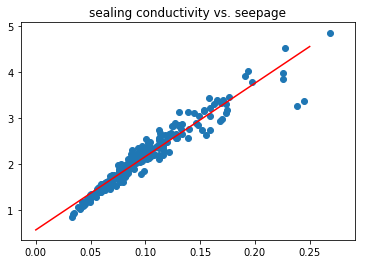

In [24]:
plt.scatter(df_simulations.conductivity_sealing, df_results.q_reservoir)
plt.title('sealing conductivity vs. seepage')

import scipy.stats
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_simulations.conductivity_sealing, df_results.q_reservoir)
print(r_value)
x = np.array([0, 0.25])
y = intercept + slope*x
plt.plot(x, intercept + slope*x, 'r', label='fitted line')

this is a very strong, probably dominating influence. Clearly, the hydraulich conductivity of the sealing is of significant important. This also means, that most other factor cannot have a strong influence anymore (they are accountable for the residual variability of the scatter plot).

To confirm this, we would have to evaluate all other parameters-observation combination, which can become tedious if the model is somewhat larger than this simple example.

Luckily, Pandas can do all correlations for us and present the result in the form of a correlation matrix:

In [25]:
# first, we merge both dataframes into one
df_eval = pd.concat([df_simulations, df_results], axis=1)

# plotting the complete correlation matrix.
# we need to concatenate both results and inputs before invoking the .corr method.
df_eval.corr()

,conductivity_body,conductivity_sealing,porosity,h_upstream,h_downstream,q_seepage,q_reservoir,q_drain
conductivity_body,1.000000,0.014335,-0.014711,0.498420,-0.512183,-0.216486,0.216453,0.514317
conductivity_sealing,0.014335,1.000000,-0.068011,-0.829689,0.822385,-0.964741,0.964740,-0.818339
porosity,-0.014711,-0.068011,1.000000,0.047931,-0.058741,0.083664,-0.083669,0.061284
h_upstream,0.498420,-0.829689,0.047931,1.000000,-0.992679,0.683324,-0.683340,0.988058
h_downstream,-0.512183,0.822385,-0.058741,-0.992679,1.000000,-0.693237,0.693260,-0.999325
q_seepage,-0.216486,-0.964741,0.083664,0.683324,-0.693237,1.000000,-1.000000,0.694239
q_reservoir,0.216453,0.964740,-0.083669,-0.683340,0.693260,-1.000000,1.000000,-0.694264
q_drain,0.514317,-0.818339,0.061284,0.988058,-0.999325,0.694239,-0.694264,1.000000


it may be somewhat more visual to save and copy this matrix to Excel:

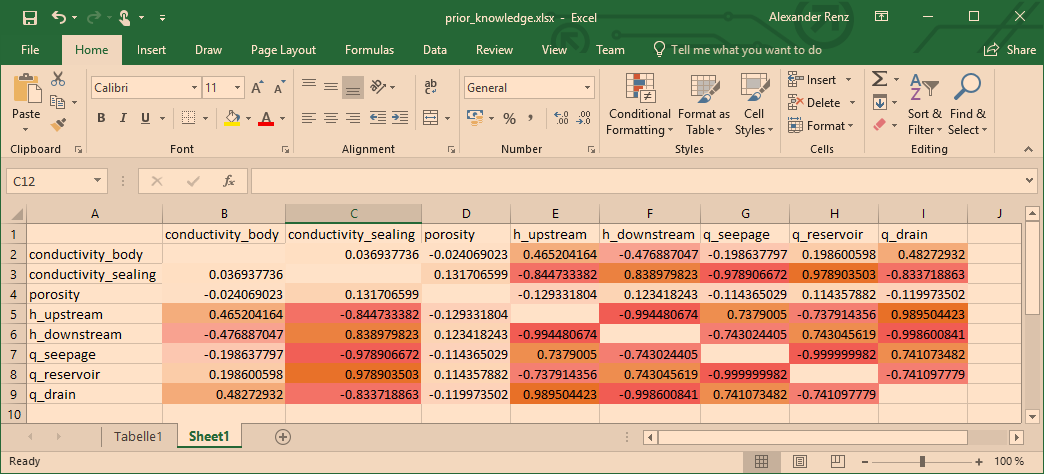

it can be clearly seen that the k-value of the sealing is dominating.


In [26]:
# hint: this is the fastest way to Excel:
df_eval.corr().to_clipboard()

Note that the matrix basically contains three types of information:

1. correlations between parameters and parameters
2. correlations between parameters and results
3. correlations between results and results

The first type is actually not an outcome, but was actually model input: when we have generated the values independently of each other, and have therefore implicitely decided that there are no correlations.

The second type is what is generally called the sensitivity analysis. It shows us which parameters are influencing which model results.

The third type is also interesting: it shows which observations are changing together when the parameters are changed. This type of correlation can be extremely valuable, especially if one of the two observations can be observed, but the other can not.

Take for example the relatively high correlation between the flux from the reservoir and the downstream hydraulic head:

Text(0,0.5,u'flux')

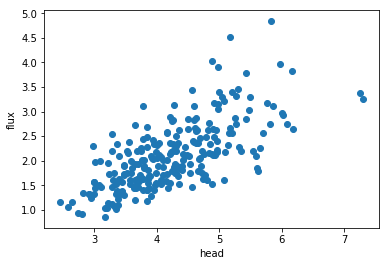

In [27]:
plt.scatter(df_eval.h_downstream, df_eval.q_reservoir)
plt.xlabel("head")
plt.ylabel("flux")

Even though there is some variation, there clearly an influence. This means that if we know something about one observation, we also gain knowledge about the other.

Let's try this out. Assume we have actually measured a downstream head of 4 m, we can calculate the model to measurement misfit.

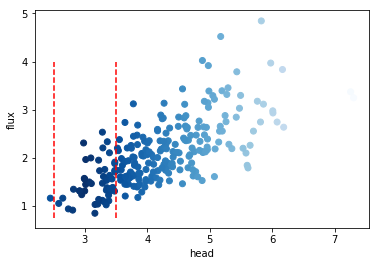

In [28]:
obs_value = 3.0
obs_noise = 0.5

df_eval["residual"] = df_eval["h_downstream"]-obs_value

plt.scatter(df_eval.h_downstream, df_eval.q_reservoir, 
            c=np.abs(df_eval.residual), cmap="Blues_r")
plt.xlabel("head")
plt.ylabel("flux")

plt.plot([obs_value-obs_noise,obs_value-obs_noise],[0.75,4],"r--")
plt.plot([obs_value+obs_noise,obs_value+obs_noise],[0.75,4],"r--")

Simulations showing a downstream hydraulic head deviating from the measurement can now be regarded as not realistic. Since they are hardly possible, we can remove these realizations from the dataset. For this example, we remove any model deviating by more than 0.5 m in downstream hydraulic head (red lines in above figure).

The histogram of the flux through the dam will now change, indicating that a different probability density function can now be used to describe the model result. This new function is called **conditional** probability, while the previous, unconstrained, distribution was called **unconditional**.

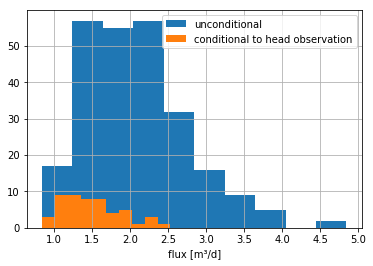

In [29]:
df_eval.q_reservoir.hist(label="unconditional")
df_eval[(df_eval.residual < obs_noise)&(df_eval.residual > -obs_noise)].q_reservoir.hist(label="conditional to head observation")
plt.xlabel(u"flux [m³/d]")
plt.legend()

We can therefore see, that by knowledge of one observation we have been able to reduce range of potential results (and therefore the predictive uncertainty) quite considerable.

The approach that is shown here is also referred to as **Monte Carlo Filtering**.

Not only the conditional probability of results has changed with knowledge of additional measurements, also the paramater values become constrained in a Bayesian sense.

Let's compare the unconditional and conditional parameter ranges for the hydraulic conductivity:

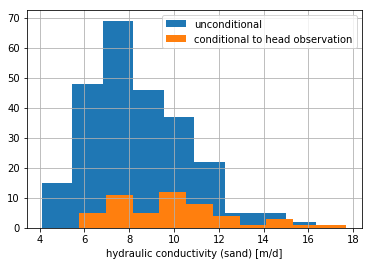

In [30]:
df_eval.conductivity_body.hist(label="unconditional")
df_eval[(df_eval.residual < obs_noise)&(df_eval.residual > -obs_noise)].conductivity_body.hist(label="conditional to head observation")
plt.xlabel(u"hydraulic conductivity (sand) [m/d]")
plt.legend()

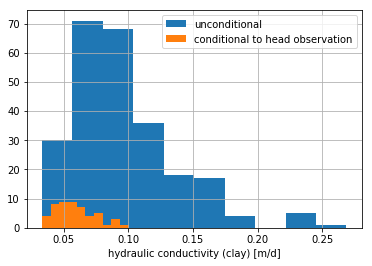

In [31]:
df_eval.conductivity_sealing.hist(label="unconditional")
df_eval[(df_eval.residual < obs_noise)&(df_eval.residual > -obs_noise)].conductivity_sealing.hist(label="conditional to head observation")
plt.xlabel(u"hydraulic conductivity (clay) [m/d]")
plt.legend()

Obviously, knowledge of the head measurement also reduced the range of conditional parameter likelyhood. In particular, the difference between max and min value is significantly reduced.

In [32]:
df_eval.to_pickle("df_eval.pickle")

## GLUE

[Generalized likelihood uncertainty estimation (GLUE)](https://en.wikipedia.org/wiki/Generalised_likelihood_uncertainty_estimation) is a Monte-Carlo based methodology developed by Beven and Binley (1992).

Using the GLUE analysis, the prior set of models, parameters and variables is divided into a set of non-acceptable solutions and a set of acceptable solutions. The GLUE methodology deals with the variable degree of membership of the sets. The degree of membership is determined by assessing the extent to which solutions fit the model, which in turn is determined by subjective likelihood functions. By abandoning the statistical framework we also abandon the traditional definition of uncertainty and in general will have to accept that to some extent uncertainty is a matter of subjective and individual interpretation by the hydrogeologist.

### Fundamentals

The GLUE methodology consists of the 4 steps:

1)	Determine the statistics for the models, parameters and variables that, prior to the investigation, are considered likely to be decisive for the simulation of the system. Typically quite wide discrete or continuous uniform distribution is chosen - reflecting the fact that there is little prior knowledge of the uncertainties arising from models, parameters and variables. In principle all available knowledge can be put into the prior distributions.

2)	Stochastic simulation based on the models, parameters and variables defined in step 1. The Monte Carlo or Latin Hypercube method may be used to do a random sample of the parameter sets. Step 2 gives us an unconditional estimate of the statistics of any system state variable.

3)	Evaluate every single simulation performed in step 2. Simulations, and thus parameter sets, are rated according to the degree to which they fit observed data. If the simulated state variables are “close” to the observed values the simulation is accepted as having a given likelihood, whereas if the considered simulated state variables are unrealistic the simulation is rejected as having zero likelihood.

4)	Repeat step 1 to 3 for every conceptual model and evaluate the results using the same likelihood function. This allows the model averaging of different conceptual models.

In this way a likelihood value is assigned to all accepted parameter sets from every simulated conceptual model (zero for rejected sets and positive for accepted sets) and a probability distribution of the target variables (such as the predicted dewatering rates or the water tables) can be estimated using all the accepted simulations.



### Choice of the Likelihood function

Likelihood is a measure of how well a given combination of models, parameters and variables fits, based on the available set of observations. The likelihood measure thus describes the degree to which the various acceptable solutions are members of the set, i.e. their degree of membership.

The calculation of the likelihood of a given set of models, parameters and variables is the key feature of the GLUE methodology, and, in this respect, GLUE differs from the classical methods of calibration and uncertainty estimation.

A wide range of likelihood measures are suggested - all with different qualities. There are no definitive rules for choosing a certain likelihood measure. The likelihood measure consists of three elements:

1)	a rejection level that indicates whether the acceptance criteria are fulfilled or not,

2)	a point likelihood measure that sums up the degree of model fit in the individual observation points and

3)	a global likelihood measure that is an aggregation of all the point likelihood measures.

Often the rejection level is implicitly given in the point likelihood function, and occasionally the rejection level, the point likelihood measure and the global likelihood measure are all gathered in one function.

The following two defintions have been used here:

#### Beven-Binley Likelihood function (BB)

The likelihood function used by Binley and Beven (1991 – B&B) which is also based on the sum of squares of the residuals as

$$L =(\sigma_e^2)^{-N}$$

where N is a parameter chosen by the user. Note that when $N=0$, every simulation will have equal likelihood and when $N\rightarrow\inf $ the single best simulation will have a likelihood of 1 while all the others will have a likelihood of zero.

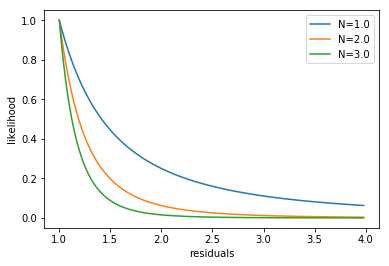

In [33]:
def L_bb(residuals, N):
    return pow(residuals**2, -float(N))

x = np.arange(1, 4, 0.02)
plt.plot(x, [L_bb(p, 1) for p in x], label="N=1.0")
plt.plot(x, [L_bb(p, 2) for p in x], label="N=2.0")
plt.plot(x, [L_bb(p, 3) for p in x], label="N=3.0")
plt.xlabel("residuals")
plt.ylabel("likelihood")
plt.legend()

#### Coefficient of Determination (CD)

A model efficiency or coefficient of determination (CD) defined by

$$L = 1 - \frac{\sigma_e^2}{\sigma_o^2}$$

Which is 0 when the variance of the residuals $\sigma_e^2$ and $\sigma_o^2$.

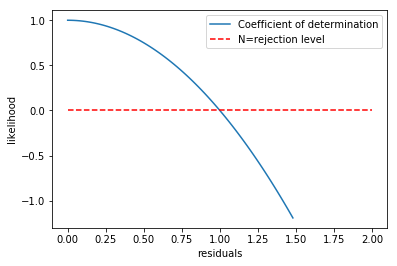

In [34]:
def L_cd(residual, observation):
    return 1 - residual**2 / observation**2

x = np.arange(0, 1.5, 0.02)
plt.plot(x, [L_cd(p, 1) for p in x], label="Coefficient of determination")
plt.xlabel("residuals")
plt.ylabel("likelihood")
plt.plot([0, 2], [0, 0], "r--", label="N=rejection level")
plt.legend()

Keep in mind that likelihood is a subjective measure. 

In this case, I have used the CD function with 0.5 m as lowest acceptable residual.
This allows to calculate a likelihood function for each of the scenarios.

In [35]:
def fab(x):
    return L_cd(x, obs_noise)
df_eval["L"] = df_eval["residual"].apply(fab)
df_eval

,conductivity_body,conductivity_sealing,porosity,h_upstream,h_downstream,q_seepage,q_reservoir,q_drain,residual,L
0,9.376085,0.103821,0.203140,11.989088,4.204607,-2.351930,2.352438,-0.000411,1.204607,-4.804312
1,6.083403,0.089210,0.153487,11.986483,4.710323,-1.892093,1.892589,-0.000463,1.710323,-10.700817
2,6.798915,0.083286,0.170221,11.988195,4.379422,-1.846931,1.847337,-0.000429,1.379422,-6.611222
3,8.696379,0.065599,0.304615,11.991970,3.568639,-1.606052,1.606379,-0.000344,0.568639,-0.293400
4,6.369990,0.102663,0.255863,11.985504,4.887363,-2.128187,2.128536,-0.000481,1.887363,-13.248556
5,9.732650,0.065484,0.199067,11.992697,3.396185,-1.633461,1.633828,-0.000326,0.396185,0.372149
6,6.722493,0.100664,0.112131,11.986278,4.753697,-2.125746,2.126109,-0.000468,1.753697,-11.301818
7,6.598755,0.173832,0.274713,11.979592,5.860136,-3.114276,3.114682,-0.000576,2.860136,-31.721502
8,7.097622,0.044139,0.148194,11.993162,3.280164,-1.115142,1.115496,-0.000312,0.280164,0.686033
9,5.054297,0.155145,0.237077,11.977507,6.184481,-2.635564,2.635727,-0.000609,3.184481,-39.563668


First we can filter out the rejected values, which leads to the same conditional distributions as for the previous Monte-Carlo Filtering approach.

*Note: The Histograms below have been normed thus that their area is equalized. This is a better representation of PDF functions. They have been made slightly translucent to to improve readability.*

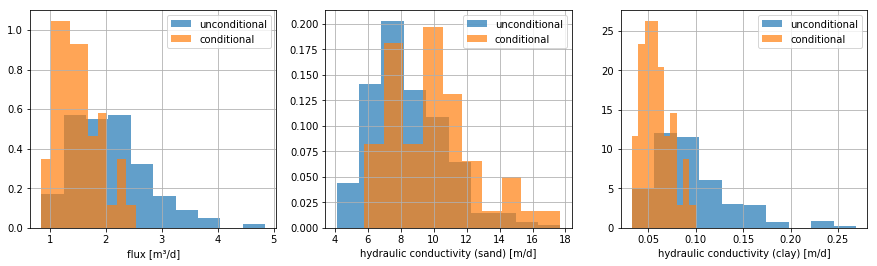

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

df_eval.q_reservoir.hist(label="unconditional", normed=True, alpha=0.7, ax=ax1)
df_eval[df_eval.L > 0].q_reservoir.hist(label="conditional", normed=True, alpha=0.7, ax=ax1)
ax1.set_xlabel(u"flux [m³/d]")
ax1.legend()

df_eval.conductivity_body.hist(label="unconditional", normed=True, alpha=0.7, ax=ax2)
df_eval[df_eval.L > 0].conductivity_body.hist(label="conditional", normed=True, alpha=0.7, ax=ax2)
ax2.set_xlabel(u"hydraulic conductivity (sand) [m/d]")
ax2.legend()

df_eval.conductivity_sealing.hist(label="unconditional", normed=True, alpha=0.7, ax=ax3)
df_eval[df_eval.L > 0].conductivity_sealing.hist(label="conditional", normed=True, alpha=0.7, ax=ax3)
ax3.set_xlabel(u"hydraulic conductivity (clay) [m/d]")
ax3.legend()

applying L as a weighting factor to the values during the binning process applies a higher weight to simulations showing a better fit to the observation data.

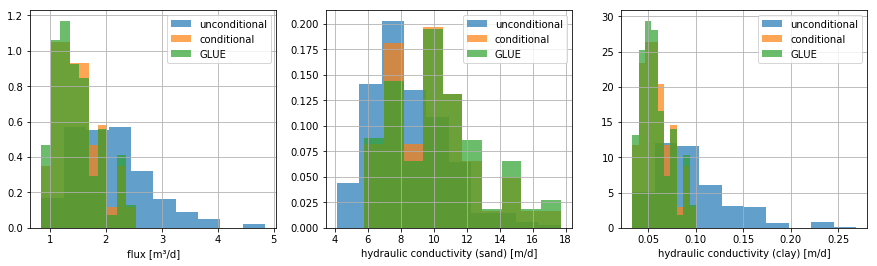

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

df_eval.q_reservoir.hist(label="unconditional", normed=True, alpha=0.7, ax=ax1)
df_eval[df_eval.L > 0].q_reservoir.hist(label="conditional", normed=True, alpha=0.7, ax=ax1)
df_eval[df_eval.L > 0].q_reservoir.hist(label="GLUE", weights=df_eval[df_eval.L > 0].L.values, normed=True, alpha=0.7, ax=ax1)
ax1.set_xlabel(u"flux [m³/d]")
ax1.legend()

df_eval.conductivity_body.hist(label="unconditional", normed=True, alpha=0.7, ax=ax2)
df_eval[df_eval.L > 0].conductivity_body.hist(label="conditional", normed=True, alpha=0.7, ax=ax2)
df_eval[df_eval.L > 0].conductivity_body.hist(label="GLUE", weights=df_eval[df_eval.L > 0].L.values, normed=True, alpha=0.7, ax=ax2)
ax2.set_xlabel(u"hydraulic conductivity (sand) [m/d]")
ax2.legend()

df_eval.conductivity_sealing.hist(label="unconditional", normed=True, alpha=0.7, ax=ax3)
df_eval[df_eval.L > 0].conductivity_sealing.hist(label="conditional", normed=True, alpha=0.7, ax=ax3)
df_eval[df_eval.L > 0].conductivity_sealing.hist(label="GLUE", weights=df_eval[df_eval.L > 0].L.values, normed=True, alpha=0.7, ax=ax3)
ax3.set_xlabel(u"hydraulic conductivity (clay) [m/d]")
ax3.legend()